# Importing Libraries

In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

In [3]:
from operator import add

from typing import Annotated, Any, TypedDict

from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel

class InputState(BaseModel):
    string_value: Annotated[str, add]

In [4]:
def append_a(state: InputState) -> Any:
    print(f"append_a: Current string_value: '{state.string_value}'")
    state.string_value += "a"
    return state

def append_b(state: InputState) -> Any:
    print(f"append_b: Current string_value: '{state.string_value}'")
    state.string_value += "b"
    return state

def append_c(state: InputState) -> Any:
    print(f"append_c: Current string_value: '{state.string_value}'")
    state.string_value += "c"
    return state


def combine_strings(state: InputState) -> Any:
    combined_string = state.string_value
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    state.string_value = final_string
    return state

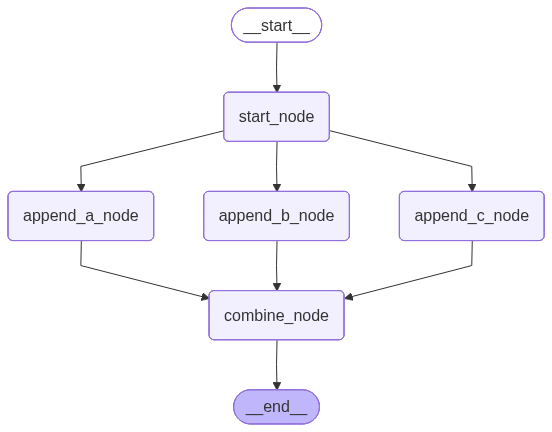

In [7]:
builder = StateGraph(InputState)

builder.add_node("start_node", lambda state: state)

builder.add_node("append_a_node", append_a)
builder.add_node("append_b_node", append_b)
builder.add_node("append_c_node", append_c)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")

builder.add_edge("start_node", "append_a_node")
builder.add_edge("start_node", "append_b_node")
builder.add_edge("start_node", "append_c_node")

builder.add_edge("append_a_node", "combine_node")
builder.add_edge("append_b_node", "combine_node")
builder.add_edge("append_c_node", "combine_node")

builder.add_edge("combine_node", END)

graph = builder.compile()

graph

In [9]:
initial_state = {"string_value": ""}

result = graph.invoke(initial_state)
result

append_a: Current string_value: ''
append_b: Current string_value: ''
append_c: Current string_value: ''
combine_strings: Combined string_value='abc'
combine_strings: Final string_value='ABC'


{'string_value': 'abcABC'}

# Mapreduce with Send API

In [2]:
from operator import add
import random

from typing import Annotated, List, Any, Optional, TypedDict

from langgraph.graph import StateGraph, END, START
from langgraph.types import Send

# class State(BaseModel):
#     string_value: Annotated[str, add]
#     letters: Optional[List[str]] = []

class State(TypedDict):
    string_value: Annotated[str, add]
    letters: List[str]

In [ ]:
# def generate_letters(_: State) -> Any:
#     num_nodes = random.randint(5, 10)
#     letters = random.choices(["a", "b", "c", "d", "e"], k=num_nodes)
#     print(f"Generated letters: {letters}")
#     return {"letters": letters}

# def generate_random_nodes(state: State):
#     letters = state.letters
#     print(f"using letters from state: {letters}")
#     return [Send("append_letter", {"letter": letter}) for letter in letters]

# def append_letter(state: State) -> Any:
#     letter = state.letter
#     print(f"Appending '{letter}'")
#     return {"string_value": letter}

# def combine_strings(state: State) -> Any:
#     combined_string = state.string_value
#     print(f"combine_strings: Combined string_value='{combined_string}'")
#     final_string = combined_string.upper()
#     print(f"combine_strings: Final string_value='{final_string}'")
#     return {"string_value": final_string}

In [3]:
def generate_letters(_: State) -> Any:
    num_nodes = random.randint(5, 10)
    letters = random.choices(["a", "b", "c", "d", "e"], k=num_nodes)
    print(f"Generated letters: {letters}")
    return {"letters": letters}

def generate_random_nodes(state: State):
    letters = state['letters']
    print(f"using letters from state: {letters}")
    return [Send("append_letter", {"letter": letter}) for letter in letters]

def append_letter(state: State) -> Any:
    letter = state['letter']
    print(f"Appending '{letter}'")
    return {"string_value": letter}

def combine_strings(state: State) -> Any:
    combined_string = state['string_value']
    print(f"combine_strings: Combined string_value='{combined_string}'")
    final_string = combined_string.upper()
    print(f"combine_strings: Final string_value='{final_string}'")
    return {"string_value": final_string}

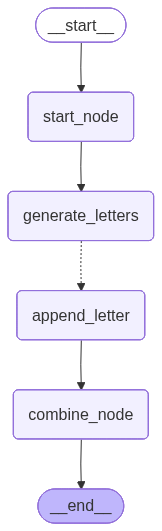

In [4]:
builder = StateGraph(State)
builder.add_node("start_node", lambda state: State)

builder.add_node("generate_letters", generate_letters)
builder.add_node("append_letter", append_letter)
builder.add_node("combine_node", combine_strings)

builder.add_edge(START, "start_node")
builder.add_edge("start_node", "generate_letters")
builder.add_conditional_edges(
    "generate_letters", generate_random_nodes, ["append_letter"]
)

builder.add_edge("append_letter", "combine_node")
builder.add_edge("combine_node", END)


graph = builder.compile()

graph

In [6]:
initial_state = {"string_value": ""}
result = graph.invoke(initial_state)

result

InvalidUpdateError: Expected dict, got <class '__main__.State'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE